# Performance of LSH for coreferences

In [7]:
from load_coreferences import load_coreferences, load_pairs
# import lsh 
from REL import lsh 
import copy
import numpy as np
import time 
import matplotlib.pyplot as plt
import math 
import cProfile

scaling_factor = 5 # multiply size the original data set by this factor

In [2]:
all_pairs = load_pairs(validate_or_test="validate")
raw_mentions = load_coreferences(validate_or_test="validate")
mentions = {i: m for i, m in enumerate(raw_mentions)}


#### Effectiveness

In [3]:
def evaluate_coref_predictions(pairs_gold, candidates, _return = False):
    "Precision and recall for LSH coref pair search"
    missed = 0 
    correct = 0 
    wrong = 0

    for mention, true_reference in pairs_gold.items():
        current_candidates = candidates[mention]

        if true_reference not in current_candidates:
            missed += 1
        for candidate in current_candidates:
            if candidate == true_reference:
                correct += 1
            elif candidate != true_reference:
                wrong += 1


    precision = correct / (correct + wrong)
    recall = correct / (correct + missed)

    ndig = 3
    if not _return:
        print(f"Precision: {round(precision, ndig)}") # note: lower precision means larger comparison set for coref classification.
        print(f"Recall: {round(recall, ndig)}") 
    else:
        return (precision, recall)

In [4]:
pairs_gold = {}
for pair_doc in all_pairs.values():
    for p in pair_doc:
        pairs_gold[p[1]] = p[0] # key = mention, value = true coreference



Make signature with a while loop 

In [29]:

band_length = math.ceil(math.log(len(mentions)))
# mylsh = lsh.LSHRandomProjections(mentions=mentions, shingle_size=2, n_bands=150, band_length=band_length) # old: 2, 400, 15
mylsh = lsh.LSHRandomProjections(mentions=mentions, shingle_size=2, n_bands=15, band_length=band_length) # old: 2, 400, 15
mylsh.cluster()
mylsh.summarise()
candidates = {mention: [mentions[i] for i in mylsh.candidates[idx]] for idx, mention in mentions.items()}

evaluate_coref_predictions(pairs_gold, candidates)

mylsh.efficiency_gain_comparisons()

took 0.010871410369873047 seconds for 453 mentions
average, min, max cluster size: 73.29, 37, 119
Precision: 0.011
Recall: 0.849
LSH makes fraction 0.16 of comparisons relative to option all.


In [14]:
# old approach 
n_bands_min = 2
n_bands_max = 150
steps_bands = 20
# band_lengths = [2, 3, 4] # varying band lengths gives not strictly increasing ROC curve
band_lengths = [band_length]# old: 15
shingle_sizes = [2,3,4]

measure_dict = {}

for shingle_size in shingle_sizes:
    l = band_lengths[0]
    measurements = []
    # start_size = min_signature_size - (min_signature_size % l) + l # start at next multiple of l
    for n in range(n_bands_min, n_bands_max, steps_bands):
        mylsh = lsh.LSHRandomProjections(mentions=mentions, shingle_size=shingle_size, n_bands=n, band_length=l)

        mylsh.cluster()
        candidates = {mention: [mentions[i] for i in mylsh.candidates[idx]]  for idx, mention in mentions.items()}

        m = evaluate_coref_predictions(pairs_gold, candidates, _return=True)
        out = m + (n,)
        measurements.append(out)
    measure_dict[shingle_size] = measurements

Properties    
- longer signature $\rightarrow$ higher recall, lower precision
- larger shingle $\rightarrow$ lower recall, higher precision
- longer band $\rightarrow$ lower recall, higher precision


In [15]:
md = {k: [
    [1 - i[0] for i in measures], # fpr
    [i[1] for i in measures], # recall,
    [i[2] for i in measures] # n_bands
] for k, measures in measure_dict.items()}


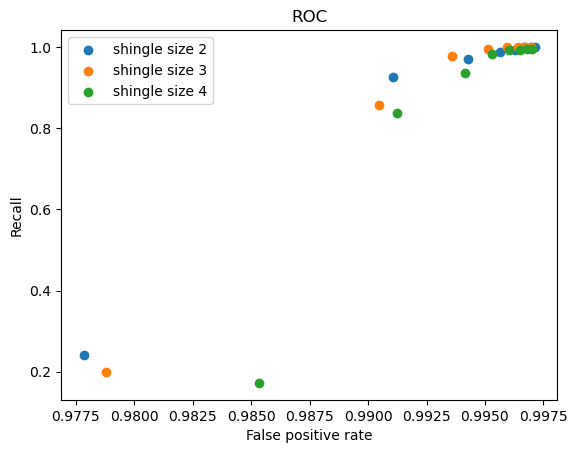

In [16]:
fig, ax = plt.subplots()
for k, v in md.items():
    lbl = f"shingle size {k}"
    ax.scatter(x=v[0], y=v[1], label=lbl)

ax.set_xlabel("False positive rate")
ax.set_ylabel("Recall")
ax.set_title("ROC")
ax.legend()

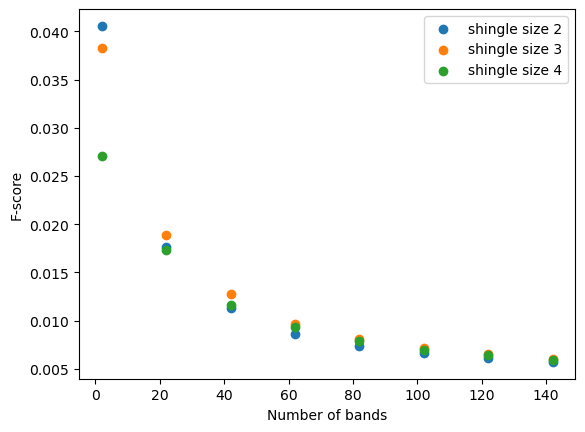

In [17]:
fig, ax = plt.subplots()
for k, v in md.items():
    precision = np.array([1-i for i in v[0]])
    recall = np.array([i for i in v[1]])
    fscore = 2 * precision * recall / (precision + recall)
    lbl = f"shingle size {k}"
    ax.scatter(y=fscore, x=v[2], label=lbl)

ax.set_ylabel("F-score")
ax.set_xlabel("Number of bands")
ax.legend()

Notes 
- trade off: get the same recall for smaller false positive rate with larger shingle size, but need a larger signature and thus more time 
    - improve the calculation of the signature?
    - another benefit however is that with a smaller false positive rate, the `with_coref` call in REL will be faster (smaller comparison sets)
    - also important: higher false positive rate means more comparisons also for those mentions that are *not* coreferences (and are not in the present dataset).
    - check again the time complexity of this -- signature length of 300 may not be feasible/lead to long computing time when data set is a few thousands of mentions
- add color shading for shingle size? 

#### Profiling

In [29]:

# stack mentions on top of each other 
mentions_scaled = copy.copy(mentions)

idx = len(mentions_scaled)
for i in range(1, scaling_factor):
    for idx_old in mentions.keys():
        m = mentions[idx_old]
        mentions_scaled[idx] = m 
        idx += 1